### stage dataset

build a stage dataset with feature extraction


# Imports

In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [24]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/3.StageDataset'

In [25]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']


In [26]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [27]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### overall view of laptime scatter plots



In [28]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

In [29]:
def draw_laptime(ax, ycol='LapTime'):
    
    ymax = np.max(y)
    
    #yellow flags
    for yflag in yellowflags:
        ax.bar(yflag[0],ymax, width = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)

    #plt.plot(np.arange(laptime.shape[0]), laptime, marker='.')
    ax.scatter(x, y, marker='.')    

    #pit stops    
    ax.scatter(pits, y[pits-1], marker='x', color='r')
    for pit in pits:
        ax.bar(pit,height = y[pits-1], width = .8, align='center', color = 'r', zorder=-100)
    
    #ax.set_xlim((0, 33))
    #ax.set_ylim((0, 201))
    ax.set_xlabel('Lap')
    ax.set_ylabel(ycol)
    
def draw_pitstop(ax, pits):
    #pit stops    
    ax.scatter(pits, y[pits-1], marker='x', color='r')
    for pit in pits:
        ax.bar(pit,height = y[pits-1], width = .8, align='center', color = 'r', zorder=-100)

    
def draw_yellowflag(ax,yellowflags):
    ymax = np.max(y)
    #yellow flags
    for yflag in yellowflags:
        ax.bar(yflag[0],ymax, width = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)

### bulid the dataset

In [30]:
def get_stagedata(TRIM=2):
    """
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]

        pits=[]
        yellowflags=[]
        lastflag = 'x'
        
        stage = 0
        start_lap = 0
        pit_lap = 0
        pit_in_caution = 0
        for row in carstatus:
            lap = int(row[colid['completed_laps']])
            
            if lap==0:
                #hex2int
                start_rank = int(row[colid['start_position']], 16)     
            
            if row[colid['lap_status']]=='P':
                pits.append(lap)
                end_lap = lap - TRIM
                end_rank = carstatus[end_lap][colid['rank']]
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
                data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
                # prepare for the next
                stage += 1
                start_lap = end_lap  # end_lap + 1?
                start_rank = end_rank
                pit_lap = lap  #current is pit lap
                pit_in_caution = 1 if row[colid['track_status']]=='Y' else 0
                

            if row[colid['track_status']]=='Y':
                if lastflag != 'Y':       
                    #start
                    yellowflags.append(lap)
            else:
                if lastflag == 'Y':       
                    #end
                    yellowflags.append(lap)        
            lastflag = row[colid['track_status']]

        #final
        end_lap = carstatus[-1][colid['completed_laps']]
        end_rank = carstatus[-1][colid['rank']]
        #add one record
        #stagedata['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
        data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
        
        #pit lap
        pits = np.array(pits)
        #start, end lap
        #
        yellowflags = np.array(yellowflags)
        if (yellowflags.shape[0] % 2)==1:
            print('crash?:carno=', curcarno)
            yellowflags = []
        else:
            yellowflags = np.array(yellowflags).reshape((-1,2))  
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7]})
    return df, data

### events

In [41]:
def extract_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)
    
    target
    eventid
    car_number
    stageid
    
    #0, gobal info 
    firststage  ;  1/0    
    pit_in_caution; 1/0
    start_position  ; #
    
    # 0 order of #rank
    start_rank  ;  #rank
    start_rank_ratio; ; #rank/carnum 
    top_pack    ;  top5 1/0 
    bottom_pack  ; bottom5 1/0 
    
    average_rank  ; previous stage
    average_rank_all  ; all previous stages
    
    # 1 order of #rank
    change_in_rank; previous stage
    change_in_rank_all;  all previous stages
    # 2 order of #rank
    rate_of_change; previous stage
    rate_of_change_all;  all previous stages
    
    #neighbors;   
    prev_nb0_change_in_rank
    prev_nb1_change_in_rank
    prev_nb2_change_in_rank
    follow_nb0_change_in_rank
    follow_nb1_change_in_rank
    follow_nb2_change_in_rank
    
    """
    eventid = 0
    cols=['target','eventid','car_number','stageid',
             'firststage','pit_in_caution','start_position',
             'start_rank','start_rank_ratio','top_pack','bottom_pack',
             'average_rank','average_rank_all',
             'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all']
             #'prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
             #'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['car_number','stage','start_lap','end_lap','pit_lap', 'pit_in_caution', 'start_rank','end_rank']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)
        
        records = []
        
        laphist = []
        rankhist = []
        rankchghist = []        
        #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution, 'start_rank','end_rank']
        for row in data:
            # a new record
            rec={}
            #status, 'start_lap', start a new car
            if row[datacolid['start_lap']] == 0:
                start_position = row[datacolid['start_rank']]
                laphist = []
                rankhist = []
                rankchghist = []
            
            #target 
            rec['target'] = row[datacolid['end_rank']] - row[datacolid['start_rank']]
            
            #features
            rec['eventid'] = eventid
            rec['car_number'] = row[datacolid['car_number']]
            rec['stageid'] = row[datacolid['stage']]
            rec['firststage'] = 0 if row[datacolid['stage']]==0 else 1
            rec['pit_in_caution'] = row[datacolid['pit_in_caution']]
            rec['start_position'] = start_position
            rec['start_rank'] = row[datacolid['start_rank']]
            rec['start_rank_ratio'] = rec['start_rank'] / totalcars
            rec['top_pack'] = 1 if rec['start_rank']<=5 else 0
            #todo, not accurate here
            rec['bottom_pack'] = 1 if rec['start_rank']>=totalcars-5 else 0
            #get from laphist
            if laphist:
                #previous stage
                prev_stage = laphist[-1]
                rec['average_rank'] = np.mean(list(prev_stage['rank']))
                rec['average_rank_all'] = np.mean(rankhist)
            else:
                rec['average_rank'] = rec['start_rank']
                rec['average_rank_all'] = rec['start_rank']
                
            #change in rank
            if rankchghist:
                rec['change_in_rank'] = rankchghist[-1]
                rec['change_in_rank_all'] = np.mean(rankchghist)
            else:
                rec['change_in_rank'] = 0
                rec['change_in_rank_all'] = 0
                
            #rate of change in rank
            if len(rankchghist)>2:
                rec['rate_of_change'] = rankchghist[-1] - rankchghist[-2]
                rec['rate_of_change_all'] = (rankchghist[-1] - rankchghist[0])/(len(rankchghist)-1)
            else:
                rec['rate_of_change'] = 0
                rec['rate_of_change_all'] = 0            
            
            #add one record
            records.append([rec[col] for col in cols])
            
            #update for the new stage
            lapdata = rankdata[(rankdata['car_number']== rec['car_number']) & 
                               (rankdata['completed_laps']>=row[datacolid['start_lap']]) &
                               (rankdata['completed_laps']<row[datacolid['end_lap']])
                              ]
            laphist.append(lapdata)
            rankhist.extend(list(lapdata['rank']))
            rankchghist.append(row[datacolid['end_rank']] - row[datacolid['start_rank']])
          
        # push this event into stage dataframe
        print('eventid=%d, records=%d'%(eventid, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df])
        
        #for the next new event
        eventid += 1
        
    return stagedf

In [42]:
df = extract_features(stagedata)
df

eventid=0, records=114
eventid=1, records=225
eventid=2, records=127
eventid=3, records=109
eventid=4, records=126
eventid=5, records=104


,target,eventid,car_number,stageid,firststage,pit_in_caution,start_position,start_rank,start_rank_ratio,top_pack,bottom_pack,average_rank,average_rank_all,change_in_rank,change_in_rank_all,rate_of_change,rate_of_change_all
0,0,0,1,0,0,0,7,7,0.304348,0,0,7.000000,7.000000,0,0.000000,0,0.000000
1,-5,0,1,1,1,1,7,7,0.304348,0,0,7.025641,7.025641,0,0.000000,0,0.000000
2,3,0,1,2,1,0,7,2,0.086957,1,0,2.328947,3.921739,-5,-2.500000,0,0.000000
3,-4,0,1,3,1,0,7,5,0.217391,1,0,5.736842,4.523256,3,-0.666667,8,1.500000
4,0,0,1,4,1,1,7,1,0.043478,1,0,3.071429,4.166667,-4,-1.500000,-7,-1.333333
5,-1,0,4,0,0,0,16,16,0.695652,0,0,16.000000,16.000000,0,0.000000,0,0.000000
6,-3,0,4,1,1,1,16,15,0.652174,0,0,15.025641,15.025641,-1,-1.000000,0,0.000000
7,3,0,4,2,1,1,16,12,0.521739,0,0,14.500000,14.976744,-3,-2.000000,0,0.000000
8,7,0,4,3,1,0,16,15,0.652174,0,0,16.887324,16.166667,3,-0.333333,6,2.000000
9,-1,0,4,4,1,0,16,22,0.956522,0,1,10.600000,15.932773,7,1.500000,4,2.666667


In [44]:
df.to_csv('stage-%s.csv'%year)

In [22]:
df = pd.DataFrame([],columns=['eventid','car_number','stageid',
                                  'firststage','pit_in_caution','start_position',
                                 'start_rank','start_rank_ratio','top_pack','bottom_pack',
                                 'average_rank','average_rank_all',
                                 'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all',
                                 'prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
                                 'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank'])
df

,eventid,car_number,stageid,firststage,pit_in_caution,start_position,start_rank,start_rank_ratio,top_pack,bottom_pack,...,change_in_rank,change_in_rank_all,rate_of_change,rate_of_change_all,prev_nb0_change_in_rank,prev_nb1_change_in_rank,prev_nb2_change_in_rank,follow_nb0_change_in_rank,follow_nb1_change_in_rank,follow_nb2_change_in_rank


In [32]:
stagedata = {}
traindata = None
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))
    
    stage, data = get_stagedata(4)
    stagedata[event] = (alldata, rankdata, acldata, flagdata, stage, data)
    
    if traindata is None:
        traindata = data
    else:
        traindata = np.vstack((traindata, data))


count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30}
#cars= 11
count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98}
#cars= 23


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Phoenix: carno=23, lapnum=251
crash?:carno= 10
crash?:carno= 19
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33
Indy500: carno=33, lapnum=201
crash?:carno= 3
crash?:carno= 24
crash?:carno= 33
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {5, 9, 10, 15, 18, 22, 27, 28, 30}
#cars= 9
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 47, 55, 57, 59, 60, 68, 73, 83, 88, 98}
#cars= 32
Texas: carno=32, lapnum=249
crash?:carno= 12
crash?:carno= 19
count of completed cars: 5
complet

In [21]:
stagedata['Indy500'][4].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
car_number    225 non-null int64
stage         225 non-null int64
start_lap     225 non-null int64
end_lap       225 non-null int64
start_rank    225 non-null int64
end_rank      225 non-null int64
dtypes: int64(6)
memory usage: 10.6 KB


In [11]:
def generate_data(dataset, D= 1):
    # dataset with multiple events, car_number is encoded with event id
    # T is the max len
    
    carNumber = len(set(dataset.car_number))
    T = 0
    for car, group in dataset.groupby('car_number'):
        T = max(T, group.shape[0])
    print('carNumber = %d, max T =%d'%(carNumber, T))
    
    #variable len of time series
    x_train , y_train = [], []
    for car, group in dataset.groupby('car_number'):
        x = list(group.time_diff)
    
        if target == 'rank':
            y = list(group.rank_diff)
        elif target =='time':
            y = list(group.time_diff)
        else:
            print('error in target setting as', target)
            return None

        #get train/label
        retlen = len(x) - D
        if retlen <=0 :
            print('error with record, too short, car = %d, len=%d'%(car,len(x)))
            continue
        
        #output
        x_train.append(x[:retlen])
        y_train.append(y[D:])
        
    if len(x_train) != carNumber:
        print('error in carNumber')
        return x_train, y_train, x
    
    #convert to np array
    X = np.zeros((carNumber, T-D, 1))
    Y = np.zeros((carNumber, T-D, 1))
    W = np.zeros((carNumber, T-D))
    for car in range(carNumber):
        reclen = len(x_train[car])
        X[car, :reclen, 0] = np.array(x_train[car])
        Y[car, :reclen, 0] = np.array(y_train[car])        
        W[car, :reclen] = 1
        
    if shuffle:
        idx = np.random.permutation(carNumber)
        X = X[idx]
        Y = Y[idx]
        W = W[idx]

    return X, Y, W


### baselines

In [12]:
# simple model
y = traindata[:,-1] - traindata[:,-2]
acc = np.sum(y==0)
print('acc:', acc/traindata.shape[0])

acc: 0.26583850931677017


In [13]:
stage, data = get_stagedata(6)

crash?:carno= 28


In [14]:
# simple model
y = data[:,-1] - data[:,-2]
acc = np.sum(y==0)
print('acc:', acc/data.shape[0])

acc: 0.25961538461538464


#### simple model, predict with current rank, change=0

trim |  accuracy
--     | --------
2  |  0.15
4  |  0.20
6  |  0.24

In [15]:
stage

,car_number,stage,start_lap,end_lap,start_rank,end_rank
0,1,0,0,53,3,4
1,1,1,53,114,4,4
2,1,2,114,171,4,5
3,1,3,171,232,5,5
4,1,4,232,248,5,7
5,4,0,0,52,18,17
6,4,1,52,107,17,18
7,4,2,107,164,18,14
8,4,3,164,174,14,16
9,4,4,174,240,16,14


### rank in group view

In [16]:
def get_grouprank(carlist, ycol='time_diff'):
    ret = []
    for carno in carlist:
        #car = acldata[acldata['car_number']==carno]
        #x = car['completed_laps'][1:].values
        #y = car[ycol][1:].values
        
        car, x, y, pits, yellowflags = get_cardata(carno,'rank')
        
        ret.append((x,y,pits))
        
    return ret, yellowflags



crash?:carno= 28


IndexError: arrays used as indices must be of integer (or boolean) type

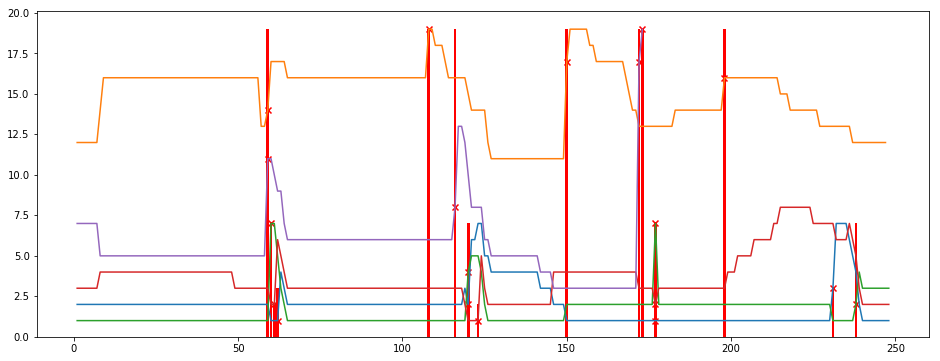

In [17]:
finalgroup = [12, 20, 9, 27, 28, 29, 1, 6, 15]
startgroup = [20, 22, 12, 1, 18, 21, 13, 3, 9, 14]

finals, yellowflags = get_grouprank(finalgroup,'rank')

fig, axes = plt.subplots(1,figsize=(16,6))
for x, y,pits in finals:
    axes.plot(x,y)
    draw_pitstop(axes, pits)
    
draw_yellowflag(axes,yellowflags)
    
fig.tight_layout()

In [ ]:
finals
get_grouprank(startgroup,'rank')

fig, axes = plt.subplots(1,figsize=(16,6))
for x, y,pits in finals:
    axes.plot(x,y)
    draw_pitstop(axes, pits)
    
draw_yellowflag(axes,yellowflags)
    
fig.tight_layout()

### conclusions

+ rank in group view, either the final top 10 group or the start top 10 group, shows relatively stable in non-pit and non-yellowflag area